# Evaluamos con algunas métricas

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import re
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Drums - KWS - Audioset

In [46]:
import itertools

metric = 'leo_metric'
value = 'leo_metric'
intersection = '0'
dataset = 'drums'
base_path = f'/home/ec2-user/evaluations/{dataset}'

files_auc = [
    f'{base_path}/{metric}_kernel_shap_sumcons_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_tree_importance_p{{}}_w{{}}_f{{}}_m{{}}_{intersection}.tsv',
]

methods = ['kernel_shap_sumcons', 'linear_regression_noreg_noweights', 'tree_importance']

ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'stat', 'noise']

dfs = []
for method, file_template in zip(methods, files_auc):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)

In [47]:
mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])[value].mean().reset_index()

In [48]:
files_auc_complete = [
    f'{base_path}/{metric}_kernel_shap_sumcons_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_linear_regression_noreg_noweights_{{}}_{intersection}.tsv',
    f'{base_path}/{metric}_tree_importance_{{}}_{intersection}.tsv',
]
names = ["0.2-1", "0.2-3", "0.2-5",
        "0.3-1", "0.3-3", "0.3-5",
        "0.4-1","0.4-3","0.4-5", 
            "zeros", "noise", "stat", "all"]

df_combinations = []
for method, file_template in zip(methods, files_auc_complete):
    for name in names:
        file_path = file_template.format(name)
        try:
            df_combination = pd.read_csv(file_path, sep='\t')
            df_combination['method'] = method
            df_combination['name'] = name
            df_combinations.append(df_combination)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

In [49]:
final_df_combination = pd.concat(df_combinations, ignore_index=True)
mean_auc_df_combination = final_df_combination.groupby(['method', 'name'])[value].mean().reset_index()

/tmp/ipykernel_2048088/1879858203.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_2048088/1879858203.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


/tmp/ipykernel_2048088/1879858203.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


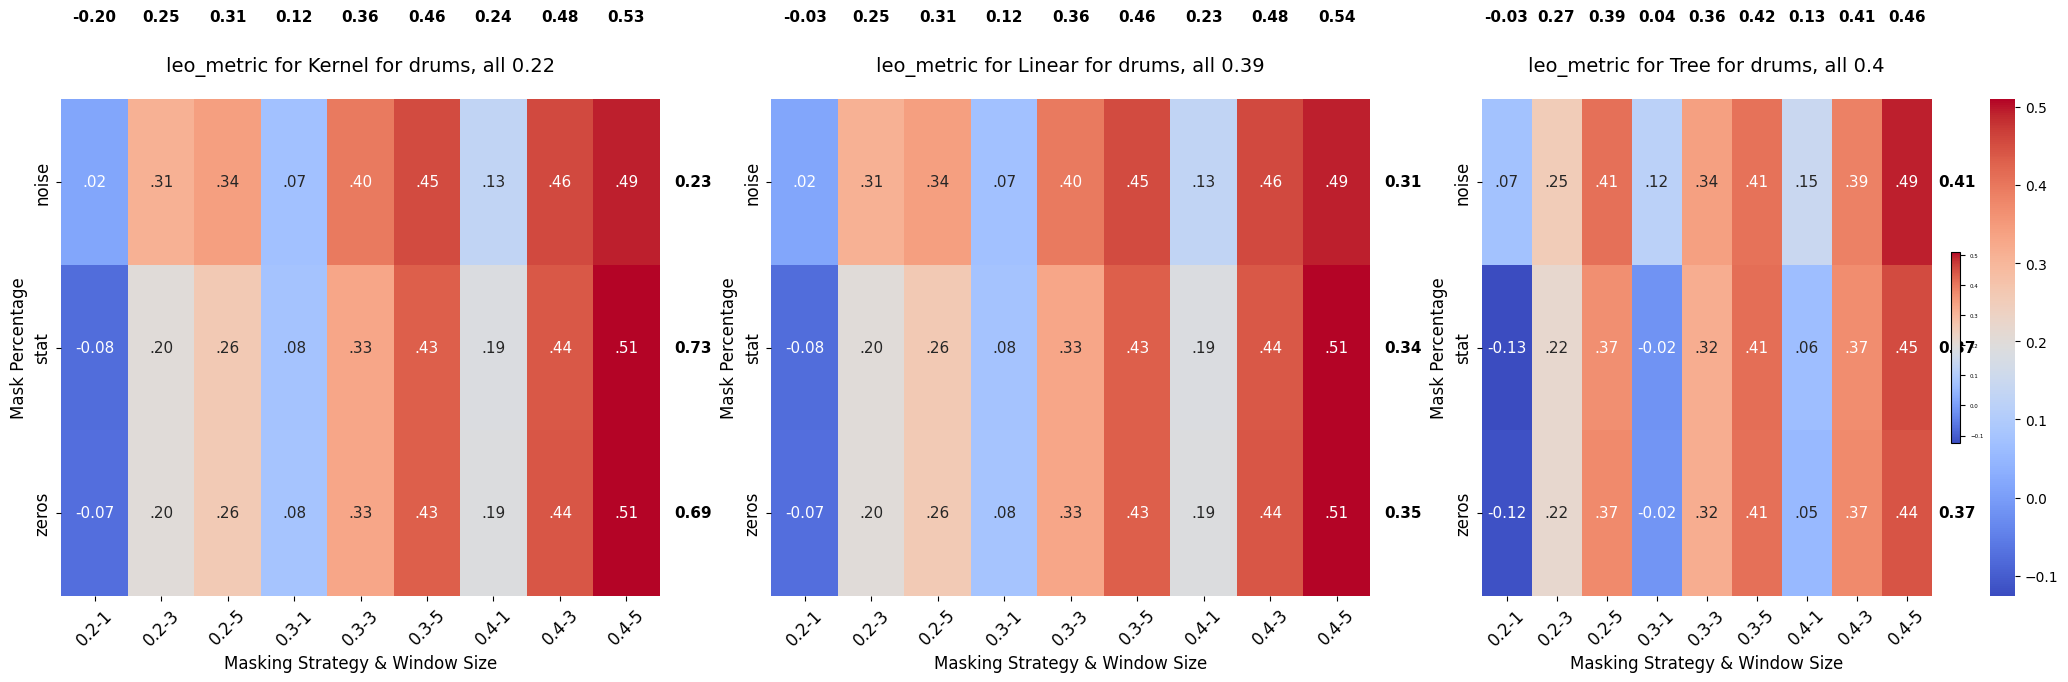

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
# Font size parameters
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df[value].max()
min_auc = mean_auc_df[value].min()

# Create a figure with subplots for each method
methods = mean_auc_df['method'].unique()
n_methods = len(methods)

# Calculate number of columns and rows
n_cols = 3  # Ceiling division to handle odd numbers
n_rows =1

# Create figure with adjusted size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 7*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Hide extra subplots if number of methods is odd
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

for idx, method in enumerate(methods):
    ax = axes[idx]

    # Create pivot table for current method
    pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values=value
    )

    # 🔹 Filter df_annotations for the current method
    annotations = mean_auc_df_combination[mean_auc_df_combination['method'] == method].set_index('name')[value]

    # 🔹 Extract values for row annotations
    row_labels = pivot_table.index
    row_annotations = [annotations.get(label, '') for label in row_labels]  # Get roc_auc or empty string

    # 🔹 Extract values for column annotations
    col_labels = pivot_table.columns
    col_annotations = [annotations.get(f"{col[0]}-{col[1]}", '') for col in col_labels]  # Convert tuple to string key

    # Create heatmap
    sns.heatmap(
        pivot_table,
        annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
        cmap="coolwarm",
        fmt="",
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods-1),
        annot_kws={'size': ANNOT_SIZE}
    )
    all = round(mean_auc_df_combination[(mean_auc_df_combination['method'] == method) & (mean_auc_df_combination['name'] == 'all')][value].values[0], 2)
    # all = 'not yet'
    method = method.split('_')[0].capitalize()
    ax.set_title(f'{metric} for {method} for {dataset}, all {all}', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Masking Strategy & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Mask Percentage', fontsize=LABEL_SIZE)

    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)
    if idx == n_methods-1:
        cbar = plt.colorbar(ax.collections[0], ax=ax, fraction=0.02, pad=0.04)
        cbar.ax.tick_params(labelsize=4)
    # 🔹 **Annotate rows (masking strategies)**
    for i, valu in enumerate(row_annotations):
        ax.text(pivot_table.shape[1] + 0.5, i + 0.5, f"{valu:.2f}" if valu else "", 
                ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')

    # 🔹 **Annotate columns (mask percentages & window sizes)**
    for j, valu in enumerate(col_annotations):
        ax.text(j + 0.5, -0.5, f"{valu:.2f}" if valu else "", 
                ha='center', va='center', fontsize=ANNOT_SIZE, color='black', fontweight='bold')

plt.tight_layout()
plt.show()


# Cough

In [11]:
import itertools

base_path = '/home/ec2-user/evaluations/cough'

files_auc_new_alg = [
    f'{base_path}/order_kernel_shap_sumcons_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_linear_regression_noreg_noweights_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_tree_importance_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_kernel_shap_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_linear_regression_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',

]

methods = ['kernel_shap_sumcons', 'linear_nocons', 'tree_importance' 'kernel_shap', 'linear_regression']
ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'stat', 'noise']

In [12]:
dfs = []
for method, file_template in zip(methods, files_auc_new_alg):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)

mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])['roc_auc'].mean().reset_index()


EmptyDataError: No columns to parse from file

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# Font size parameters
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df['roc_auc'].max()
min_auc = mean_auc_df['roc_auc'].min()

# Create a figure with subplots for each method
methods = mean_auc_df['method'].unique()
n_methods = len(methods)

# Calculate number of columns and rows
n_cols = math.ceil(n_methods / 2)  # Ceiling division to handle odd numbers
n_rows = 2

# Create figure with adjusted size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Hide extra subplots if number of methods is odd
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

# Custom formatter function to show only the decimal part
def format_value(val):
    # Convert to string with 3 decimal places and remove "0."
    return f"{(val-int(val))*100:.2f}"

for idx, method in enumerate(methods):
    ax = axes[idx]
    
    # Create pivot table for current method
    pivot_table = mean_auc_df[mean_auc_df['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values='roc_auc'
    )
    
    # Get dimensions of the pivot table
    n_rows_pivot = len(pivot_table.index)
    n_cols_pivot = len(pivot_table.columns)
    
    # Calculate aspect ratio to make cells square
    aspect = n_cols_pivot / n_rows_pivot
    
    # Create heatmap with consistent color scaling across all methods
    sns.heatmap(
        pivot_table,
        annot=True,
        cmap="coolwarm",
        fmt=format_value,  # Use custom formatter
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods-1),  # Only show colorbar for last plot
        annot_kws={'size': ANNOT_SIZE},  # Font size for annotation numbers
        square=True  # Force square cells
    )
    
    ax.set_title(f'Mean AUC for {method} for COUGH', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Masking Strategy & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Mask Percentage', fontsize=LABEL_SIZE)
    
    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)

    # If this is the last visible plot (with colorbar)
    if idx == n_methods-1:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=TICK_SIZE)

plt.tight_layout()
plt.show()

# Print the global maximum and minimum values for reference
print(f"Global maximum AUC: {(max_auc-int(max_auc))*100:.2f}")
print(f"Global minimum AUC: {(min_auc-int(min_auc))*100:.2f}")

# Drums test

In [ ]:
import itertools

base_path = '/home/cbolanos/evaluations/drums_test'

files_auc_new_alg = [
    f'{base_path}/order_linear_regression_p{{}}_w{{}}_f{{}}_m{{}}_{{}}.tsv',
    f'{base_path}/order_naive_p{{}}_w{{}}_f{{}}_m{{}}_{{}}.tsv',
    f'{base_path}/order_shap_p{{}}_w{{}}_f{{}}_m{{}}_{{}}.tsv',
    f'{base_path}/order_tree_importance_p{{}}_w{{}}_f{{}}_m{{}}_{{}}.tsv',
    f'{base_path}/order_kernel_shap_p{{}}_w{{}}_f{{}}_m{{}}_{{}}.tsv',
]

methods = ['linear_regression','naive', 'shap','tree_importance', 'kernel_shap']
ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'stat', 'noise']
values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

dfs = []
for method, file_template in zip(methods, files_auc_new_alg):
    for p, w, f, m, val in itertools.product(ps, ws, fs, ms, values):
        file_path = file_template.format(p, w, f, m, val)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            df['definicion'] = val
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)

In [14]:
final_df['group'] = final_df['method'] + '_' + \
                    final_df['mask_percentage'].astype(str) + '_' + \
                    final_df['masking_strategy'] + '_' + \
                    final_df['window_size'].astype(str)


In [ ]:
import os
import tempfile
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.animation import FuncAnimation, writers
import scipy.io.wavfile as wav
import json
import pandas as pd
import ast


def process_importance_values(values, segment_size=100, step_size=100):
    # Calculate total duration
    num_segments = len(values)
    total_duration = (num_segments - 1) * step_size + segment_size
    timeline = np.arange(0, total_duration) / 1000
    
    # Create matrix for accumulating contributions
    accumulated_importance = np.zeros(total_duration)
    
    # For each segment, distribute its importance across its duration using Bartlett window
    for i, importance in enumerate(values):
        start_idx = i * step_size
        end_idx = start_idx + segment_size
        accumulated_importance[start_idx:end_idx] += importance 

    # Calculate overlap count for normalization
    overlap_count = np.zeros(total_duration)
    for i in range(num_segments):
        start_idx = i * step_size
        end_idx = start_idx + segment_size
        overlap_count[start_idx:end_idx] += 1
    
    # Avoid division by zero and normalize
    overlap_count = np.maximum(overlap_count, 1)
    processed_importance = accumulated_importance / overlap_count
    
    return processed_importance, timeline

def read_and_process_importance_scores(file_path):
    """
    Read and process the importance scores JSON file.
    
    Args:
        file_path (str): Path to the JSON file
        
    Returns:
        dict: Processed data with metadata and processed importance scores
    """
    try:
        # Read JSON file
        with open(file_path, 'r') as f:
            data = json.load(f)
            
        # Extract metadata
        metadata = {
            'filename': data['metadata']['filename'],
            'label_explained': data['metadata']['id_explained']
        }
        
        # Process importance scores
        processed_scores = {
            'naive': {
                'method': data['importance_scores']['naive']['method'],
                'original_values': np.array(data['importance_scores']['naive']['values'])
            },
            'random_forest': {
                'tree_importance': {
                    'method': data['importance_scores']['random_forest_tree_importance']['method'],
                    'original_values': np.array(data['importance_scores']['random_forest_tree_importance']['values'])
                },
                'shap': {
                    'method': data['importance_scores']['random_forest_shap_importance']['method'],
                    'original_values': np.array(data['importance_scores']['random_forest_shap_importance']['values'])
                }
            },
            'linear_regression': {
                    'method': data['importance_scores']['linear_regression']['method'],
                    'original_values': np.array(data['importance_scores']['linear_regression']['values']['coefficients'])
            },
             'kernel_shap': {
                    'method': data['importance_scores']['kernel_shap']['method'],
                    'original_values': np.array(data['importance_scores']['kernel_shap']['values']['coefficients'])
            }
        }
        
        for key in ['naive', 'linear_regression', 'kernel_shap']:
            processed_scores[key]['processed_values'], processed_scores[key]['time_points'] = \
                process_importance_values(processed_scores[key]['original_values'])
        
        # Process random forest scores
        for key in ['tree_importance', 'shap']:
            processed_scores['random_forest'][key]['processed_values'], \
            processed_scores['random_forest'][key]['time_points'] = \
                process_importance_values(processed_scores['random_forest'][key]['original_values'])
    
        
        return {
            'metadata': metadata,
            'processed_scores': processed_scores
        }
        
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in file {file_path}")
        return None
    except KeyError as e:
        print(f"Error: Missing expected key in JSON structure: {e}")
        return None
    except Exception as e:
        print(f"Error: An unexpected error occurred: {e}")
        return None
    
def create_waveform_video_with_importances(waveform, processed_scores, output_file, 
                                         sample_rate=16000, fps=30, markers=None):
    """
    Create a video visualization of a waveform with multiple importance value plots
    
    Args:
        waveform: np.array of audio waveform
        processed_scores: dict of processed importance scores from JSON
        output_file: path to save the output video
        sample_rate: audio sample rate (default: 16000)
        fps: frames per second for video (default: 30)
        markers: list of time markers to show vertical lines (optional)
    """
    marker_colors = [
        '#FF0000',  # Red
        '#00FF00',  # Green
        '#0000FF',  # Blue
        '#FFA500',  # Orange
        '#800080',  # Purple
        '#00FFFF',  # Cyan
        '#FF00FF',  # Magenta
        '#FFD700',  # Gold
        '#98FB98',  # Pale Green
        '#DDA0DD',  # Plum
    ]
    
    with tempfile.TemporaryDirectory() as temp_dir:
        # Save the audio
        temp_audio = os.path.join(temp_dir, "temp_audio.wav")
        waveform_int16 = (waveform * 32767).astype(np.int16)
        wav.write(temp_audio, sample_rate, waveform_int16)
        
        temp_video = os.path.join(temp_dir, "temp_video.mp4")
        
        # Create time array
        times = np.arange(len(waveform)) / sample_rate
        total_duration = len(waveform) / sample_rate
        
        # Create segments for LineCollection
        points = np.array([times, waveform]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create custom colormap (light blue to dark blue)
        colors = ['#E6F3FF', '#0343DF']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        
        # Calculate number of importance plots needed
        n_importance_plots = sum([
            1,  # naive
            1,  # tree (masked, random forest)
            1,  # shap (masked, random forest)
            1,  # linear regression (masked, noise)
            1,
            1  # kernel shap (masked, noise)
        ])
        
        # Create figure and axes
        fig, axes = plt.subplots(n_importance_plots, 1, figsize=(12, 3*n_importance_plots), 
                                gridspec_kw={'height_ratios': [1]*n_importance_plots},
                                sharex=True)
        
        importance_data = []

        for key in ['kernel_shap', 'linear_regression', 'naive']:
            lime_values = processed_scores[key]['processed_values']
            lime_times = processed_scores[key]['time_points']
            importance_data.append((f'{key}', lime_values, lime_times))
    
        for key in ['tree_importance', 'shap']:
            rf_values = processed_scores['random_forest'][key]['processed_values']
            rf_times = processed_scores['random_forest'][key]['time_points']
            importance_data.append((f'Random Forest ({key})', rf_values, rf_times))
                

        for idx, (title, values, time_points) in enumerate(importance_data):
            ax = axes[idx]
            
            ax.plot(time_points, values, 'k-', linewidth=1, color='black')
            
            ax.fill_between(time_points, values, 0, alpha=0.2, color='gray')
            
            y_min = min(0, values.min())  # Include 0 in range
            y_max = values.max()
            padding = (y_max - y_min) * 0.1  # Add 10% padding
            
            ax.set_title(title)
            ax.set_ylim(y_min - padding, y_max + padding)
            ax.grid(True, alpha=0.3)
            ax.set_ylabel('Importance')
            
            # Add markers if provided
            if markers:
                for i, (start, end) in enumerate(markers):
                    # Get color from the list, cycling if needed
                    color = marker_colors[i % len(marker_colors)]
                    
                    # Add span with very light color
                    ax.axvspan(start, end, color=color, alpha=0.1)
                    
                    # Add vertical lines with stronger color
                    ax.axvline(x=start, color=color, linestyle='-', alpha=0.7, linewidth=2)
                    ax.axvline(x=end, color=color, linestyle='--', alpha=0.7, linewidth=2)
      
        ax_waveform = axes[-1]
        lc = LineCollection(segments, cmap=cmap, norm=plt.Normalize(lime_values.min(), lime_values.max()))
        lc.set_array(lime_values[:-1])  # Using naive importance for coloring
        lc.set_linewidth(1.5)
        
        ax_waveform.add_collection(lc)
        ax_waveform.set_xlim(0, total_duration)
        ax_waveform.set_ylim(waveform.min() - 0.1, waveform.max() + 0.1)
        ax_waveform.set_xlabel('Time (s)')
        ax_waveform.set_ylabel('Amplitude')
        ax_waveform.set_title('Waveform')
        
        # Adjust layout
        plt.tight_layout()
        
        # Store the previous lines to remove them in each frame
        prev_lines = []
        
        def animate(frame):
            # Remove previous lines
            for line in prev_lines:
                line.remove()
            prev_lines.clear()
            
            current_time = frame / fps
            
            # Add vertical line showing current position to all plots
            lines = []
            for ax in axes:
                line = ax.axvline(x=current_time, color='black', linestyle='-', alpha=0.3)
                lines.append(line)
                prev_lines.append(line)
            
            # Update title with current time
            axes[0].set_title(f'Importance Values Over Time (Current: {current_time:.2f}s)')
            
            return tuple(lines)
            
            # Set up the animation
        total_frames = int(total_duration * fps)
        anim = FuncAnimation(fig, animate, frames=total_frames, 
                           interval=1000/fps, blit=True)
        
        # Set up the writer
        Writer = writers['ffmpeg']
        writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
        
        # Save the animation without audio
        print("Saving temporary video...")
        anim.save(temp_video, writer=writer)
        
        # Clean up matplotlib
        plt.close()
        
        # Combine video and audio using ffmpeg
        print("Combining video and audio...")
        cmd = [
            'ffmpeg',
            '-i', temp_video,
            '-i', temp_audio,
            '-c:v', 'copy',
            '-c:a', 'aac',
            '-strict', 'experimental',
            '-y',
            output_file
        ]
        subprocess.run(cmd, check=True)
        
        print(f"Final video with audio saved as {output_file}")


def create_visualization(waveform, json_file, output_file, markers=None):
    """
    Create a complete visualization from audio and JSON files
    
    Args:
        audio_file: path to the audio file
        json_file: path to the JSON file with importance scores
        output_file: path for the output video
        markers: optional list of time markers
    """
    processed_data = read_and_process_importance_scores(json_file)

    create_waveform_video_with_importances(
        waveform=waveform,
        processed_scores=processed_data['processed_scores'],
        output_file=output_file,
        sample_rate=16000,
        markers=markers
    )

In [ ]:
from utils import create_visualization
import librosa 

waveform, fs = librosa.core.load('/mnt/data/drum_dataset/3070.wav', sr=16000)
output_file = '/home/cbolanos/results1/videoprueba.mp4'
json_file = '/home/cbolanos/results1/explanations_drums/3070.wav/drums/ft_3_p0.2_w1_feuclidean_mzeros.json'
markers = [[0.348, 1.209], [1.939, 2.29], [2.47, 2.697]]
create_visualization(waveform, json_file, output_file, markers=markers)

In [ ]:

f

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the column name for AUC is correct (assuming it's named 'auc' in your TSV files)
final_df = final_df[['method'] == 'tree_importance']
mean_auc_df = final_df.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size', 'definicion'])['roc_auc'].mean().reset_index()

mean_auc_df.head(70)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a custom color palette with distinct colors
colors = [
    '#FF1F5B', '#00CD6C', '#009ADE', '#AF58BA', '#FFC61E', 
    '#F28522', '#A0B1BA', '#A6761D', '#E9002D', '#FFAA00',
    '#00B000', '#0000FF', '#FF00FF', '#00FFFF', '#7CFFB2',
    '#8B4513', '#800080', '#4B0082', '#FFD700', '#00FF00'
]

mean_auc_df['group'] = mean_auc_df['method'] + '_' + \
                    mean_auc_df['mask_percentage'].astype(str) + '_' + \
                    mean_auc_df['masking_strategy'] + '_' + \
                    mean_auc_df['window_size'].astype(str)

# Create the figure and axis
plt.figure(figsize=(12, 6))

# Create line plot with different colors
for idx, group in enumerate(mean_auc_df['group'].unique()):
    color = colors[idx % len(colors)]  # Cycle through colors if more groups than colors
    group_data = mean_auc_df[mean_auc_df['group'] == group]
    plt.plot(group_data['definicion'], 
             group_data['roc_auc'], 
             marker='o',
             label=group,
             color=color,
             linewidth=2,
             markersize=6)

# Customize the plot
plt.title('ROC AUC vs Definition by Configuration', fontsize=14)
plt.xlabel('Definition', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)

# Rotate x-axis labels if needed
plt.xticks(rotation=0)

# Add legend with smaller font and outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          fontsize=8,
          title='Configuration')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Print summary statistics
print("\nSummary of ROC AUC values:")
print(f"Maximum ROC AUC: {mean_auc_df['roc_auc'].max():.4f}")
print(f"Minimum ROC AUC: {mean_auc_df['roc_auc'].min():.4f}")
print(f"Mean ROC AUC: {mean_auc_df['roc_auc'].mean():.4f}")

In [ ]:
mean_auc_df['group'] = mean_auc_df['method'] + '_' + \
                    mean_auc_df['mask_percentage'].astype(str) + '_' + \
                    mean_auc_df['masking_strategy'] + '_' + \
                    mean_auc_df['window_size'].astype(str)

numbers = [0.1, 0.2, 0.3, 0.4, 0.5]
for i in mean_auc_df['group'].unique():
    for j in range(len(numbers)):
        value_now = mean_auc_df[(mean_auc_df['group'] == i) & (mean_auc_df['definicion'] == numbers[j])]['roc_auc'].values[0]
        if j == len(numbers) - 1:
            value_after = mean_auc_df[(mean_auc_df['group'] == i) & (mean_auc_df['definicion'] ==  0.6)]['roc_auc'].values[0]
        else:
            value_after = mean_auc_df[(mean_auc_df['group'] == i) & (mean_auc_df['definicion'] ==  numbers[j+1])]['roc_auc'].values[0]

        if value_now < value_after:
            print(i, numbers[j], value_now, value_after)

# Audioset


In [21]:
import itertools
import ast
base_path = '/home/ec2-user/evaluations_viejas/audioset'

files_auc_new_alg = [
    f'{base_path}/order_kernel_shap_sumcons_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_linear_regression_noreg_noweights_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_tree_importance_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_kernel_shap_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',
    f'{base_path}/order_linear_regression_p{{}}_w{{}}_f{{}}_m{{}}_0.05.tsv',

]
methods = ['kernel_shap_sumcons', 'linear_nocons', 'tree_importance']
ps = [0.2, 0.3, 0.4]
ws = [1, 3, 5]
fs = ['euclidean']
ms = ['zeros', 'stat', 'noise']

dfs = []
for method, file_template in zip(methods, files_auc_new_alg):
    for p, w, f, m in itertools.product(ps, ws, fs, ms):
        file_path = file_template.format(p, w, f, m)
        try:
            df = pd.read_csv(file_path, sep='\t')
            df['method'] = method
            df['mask_percentage'] = p
            df['window_size'] = w
            df['distance_function'] = f
            df['masking_strategy'] = m
            dfs.append(df)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

final_df = pd.concat(dfs, ignore_index=True)

final_df['multisegment'] = [1 if len(ast.literal_eval(final_df['true_markers'][i])) > 1 else 0 for i in range(len(final_df))]

In [ ]:
files = ['-gBOhfAyaGI', '-JJmkQYZA-4', '0-N62G9etNE', '-Bx_-I7sB5k',
       '-k-hxP5eWko', '-spqqACI6UQ', '-XnPjiPiRAM', '-pDS3yN4B1s',
       '-HWygXWSNRA', '-ltdnlF_qMU', '-nDPmlHReow', '-XxUW9gW6mc',
       '00z0M1DJyAw', '-AeiYb4vDK0', '-gAzofSmRiY', '-Igq1W20Gi8',
       '-NrseuJrJ6k', '-qpgeVTesdE', '-oGJwGEsIiA', '-na-0NBG5Ow',
       '01SaXyGY5SM', '-IKnJa9U66I', '-PyXfNxnHKs', '-geVmY-Zo3E',
       '-ZJqu_4zLMc', '-SmkiYKIhfs', '-q6f1XIGuL4', '-Y8sJDoL1YA',
       '-mpapCZXors', '0-6N0Qagy5A', '-gKMeeAk460', '-z3n74RK92U',
       '-mKtgDnG0oM', '00wORCOKNHw', '0-o0oZvSFOk', '-Wd5YV97ftU',
       '0-yskgO46Bg', '-inB65exXFU', '-hss7xpzIVc', '-kS4J9hxMLQ',
       '-aJYgmhyrvQ', '-FoTxwPOz3U', '-qBctCzLI5s', '-ABOfhcXwt8',
       '-HKAgW-vzSI', '-Gr9P8Abnlk', '-QsPqh8Kyrc', '-G04QpzSpbU',
       '-aOxR6ILsw8', '-nJbGyPg6BY', '-uGHAvfqs2I', '-z4OZ7ls5Bo',
       '-S1mCXpSsvc', '-kPDH9n0PG4', '0-2Onbywljo', '-lcKnmO7gfo',
       '00G2vNrTnCc', '-S-TDT5oq0Q', '00iiNF4tn4o', '-XZBpMKRhok',
       '-Cdx8zogHI0', '03IZHwOh2eQ', '-klFrl9cscc', '-mmJqfAGvGs',
       '-a8dC-A_xQE', '-vg8ttgP32I', '-oC3FVOx62g', '-t-htrAtNvM',
       '-bZ4yrpTcjw', '-nv4LwXRnCg', '-Irh7_N5Kjs', '-TxhuS0jsI4',
       '01x0zZpL87I', '-cj4S5lJmYE', '-_UCboMO_xE', '-suGlxVxdCM',
       '-znnr5EbiAc', '-_HXiz8XnV0', '-gSfPQqi6nI', '-zCtwbk005g']

In [11]:
# Ensure we only keep rows where 'filename' is in the corresponding event_label's values in all_files
new_final = new_final[new_final.apply(lambda row: row['filename'] in selected_filenames.get(row['event_label'], []), axis=1)]


,filename,event_label,actual_score,real_order,model_order,roc_auc,k,true_markers,method,mask_percentage,window_size,distance_function,masking_strategy,multisegment
1,ijTDR6YQ9V4,0.0,3.462473,[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.05133228302115075, 0.09229599643146372, 0.1...",0.467917,40.0,"[[0.0, 0.22], [1.795, 3.339], [4.299, 4.614], ...",kernel_shap_sumcons,0.2,1,euclidean,zeros,1
8,mZuhtrwOS7Q,0.0,3.492690,[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.013563767875320955, 0.12927586530704566, 0...",0.597895,5.0,"[[0.0, 0.528]]",kernel_shap_sumcons,0.2,1,euclidean,zeros,0
16,hrzEf-5UmTs,0.0,2.274721,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.012644739587507562, 0.00690422562758143, 0....",0.703533,7.0,"[[7.37, 8.134]]",kernel_shap_sumcons,0.2,1,euclidean,zeros,0
26,6yvDzKEeaNA,137.0,1.661308,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[-0.04430642687096959, 0.0006342348906845357, ...",0.684211,5.0,"[[3.465, 3.992]]",kernel_shap_sumcons,0.2,1,euclidean,zeros,0
28,K3sMmfDzmyA,0.0,1.869915,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. ...,"[-0.11565815756408555, -0.07079591680647729, -...",0.515964,9.0,"[[1.215, 2.056]]",kernel_shap_sumcons,0.2,1,euclidean,zeros,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11150,DpLi9YH5idY,74.0,1.009088,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.00041722625158691507, 0.0002042929585728982...",0.985117,17.0,"[[6.652, 7.055], [7.743, 8.505], [9.537, 10.0]]",tree_importance,0.4,5,euclidean,noise,1
11157,tSX2jYLgPng,74.0,1.499506,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.007136572233359835, 0.00964965864239487, 0....",0.732248,33.0,"[[2.139, 3.395], [5.187, 5.452], [5.662, 6.008...",tree_importance,0.4,5,euclidean,noise,1
11167,cVmGCbErSyw,0.0,4.585353,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0017112009018550394, 0.0024635787820379337,...",0.764540,23.0,"[[7.701, 10.0]]",tree_importance,0.4,5,euclidean,noise,0
11171,RwvXjgK30eY,0.0,3.438339,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,"[0.0011778198240414103, 0.0009692107976607995,...",0.641569,15.0,"[[7.694, 8.26], [8.723, 9.48], [9.936, 10.0]]",tree_importance,0.4,5,euclidean,noise,1


In [13]:
new_final['filename'].unique()

array(['ijTDR6YQ9V4', 'mZuhtrwOS7Q', 'hrzEf-5UmTs', '6yvDzKEeaNA',
       'K3sMmfDzmyA', '8bRQgDQyTNw', 'yAqznhOhoIk', 'm0XHofgtfUU',
       'xvw3Z5-6h1A', 'YhEXOsZFB34', 'f1Z-HuZ-_ZA', 'IfoVNe1IcAA',
       '1nd-4Deqkro', '5ZqT7KgdYu8', 'D2o7XtW2-QA', 'qE_XwOc3COY',
       'd2yLX6TwS_c', 'FTIQ7Rr7SJI', 'BookISwJRqQ', 'lOOLf3bCY8E',
       'dFCKiXEMJA8', 'lWZGvoEHJYc', 'NbmAs1pFQM0', 'LOHw8cZZ9-U',
       'bhEVJLbRfGU', '3AFia3Uo0TQ', 'DpLi9YH5idY', 'tSX2jYLgPng',
       'cVmGCbErSyw', 'RwvXjgK30eY', 'ePaVMB0SH4Q'], dtype=object)

In [17]:
mean_auc_df = new_final.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size', 'multisegment'])['roc_auc'].mean().reset_index()

In [ ]:
new_final

/tmp/ipykernel_2048088/1909643092.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_2048088/1909643092.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


/tmp/ipykernel_2048088/1909643092.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


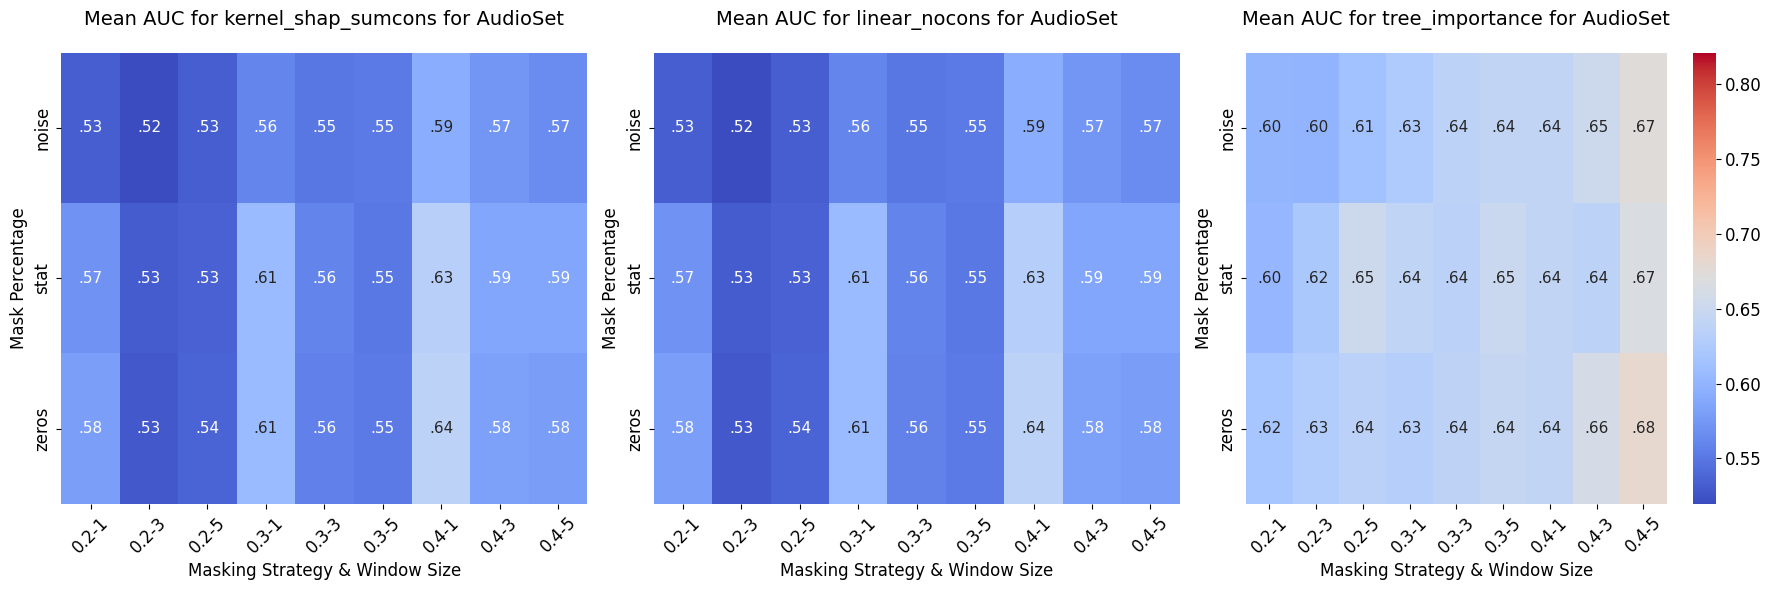

Global maximum AUC: 82.10
Global minimum AUC: 51.97


In [19]:
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = mean_auc_df['roc_auc'].max()
min_auc = mean_auc_df['roc_auc'].min()

# Create a figure with subplots for each method
methods = mean_auc_df['method'].unique()
n_methods = len(methods)

# Calculate number of columns and rows
n_cols = 3
n_rows = 1

# Create figure with adjusted size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Hide extra subplots if number of methods is odd
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

# Custom formatter function to show only the decimal part
def format_value(val):
    # Convert to string with 3 decimal places and remove "0."
    return f"{(val-int(val))*100:.2f}"

for idx, method in enumerate(methods):
    ax = axes[idx]
    
    # Create pivot table for current method
    pivot_table = mean_auc_df[(mean_auc_df['method'] == method) & (mean_auc_df['multisegment'] == 1)].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values='roc_auc'
    )
    
    # Get dimensions of the pivot table
    n_rows_pivot = len(pivot_table.index)
    n_cols_pivot = len(pivot_table.columns)
    
    # Calculate aspect ratio to make cells square
    aspect = n_cols_pivot / n_rows_pivot
    
    # Create heatmap with consistent color scaling across all methods
    sns.heatmap(
        pivot_table,
        annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
        cmap="coolwarm",
        fmt="",  # Empty format to allow manual annotation
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods-1),  # Only show colorbar for last plot
        annot_kws={'size': ANNOT_SIZE}  # Font size for annotation numbers
    )
    
    ax.set_title(f'Mean AUC for {method} for AudioSet', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Masking Strategy & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Mask Percentage', fontsize=LABEL_SIZE)
    
    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)

    # If this is the last visible plot (with colorbar)
    if idx == n_methods-1:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=TICK_SIZE)

plt.tight_layout()
plt.show()

# Print the global maximum and minimum values for reference
print(f"Global maximum AUC: {(max_auc-int(max_auc))*100:.2f}")
print(f"Global minimum AUC: {(min_auc-int(min_auc))*100:.2f}")

In [20]:
files =['-gBOhfAyaGI', '-JJmkQYZA-4', '0-N62G9etNE', '-Bx_-I7sB5k',
       '-k-hxP5eWko', '-spqqACI6UQ', '-XnPjiPiRAM', '-pDS3yN4B1s',
       '-HWygXWSNRA', '-ltdnlF_qMU', '-nDPmlHReow', '-XxUW9gW6mc',
       '00z0M1DJyAw', '-AeiYb4vDK0', '-gAzofSmRiY', '-Igq1W20Gi8',
       '-NrseuJrJ6k', '-qpgeVTesdE', '-oGJwGEsIiA', '-na-0NBG5Ow',
       '01SaXyGY5SM', '-IKnJa9U66I', '-PyXfNxnHKs', '-geVmY-Zo3E',
       '-ZJqu_4zLMc', '-SmkiYKIhfs', '-q6f1XIGuL4', '-Y8sJDoL1YA',
       '-mpapCZXors', '0-6N0Qagy5A', '-gKMeeAk460', '-z3n74RK92U',
       '-mKtgDnG0oM', '00wORCOKNHw', '0-o0oZvSFOk', '-Wd5YV97ftU',
       '0-yskgO46Bg', '-inB65exXFU', '-hss7xpzIVc', '-kS4J9hxMLQ',
       '-aJYgmhyrvQ', '-FoTxwPOz3U', '-qBctCzLI5s', '-ABOfhcXwt8',
       '-HKAgW-vzSI', '-Gr9P8Abnlk', '-QsPqh8Kyrc', '-G04QpzSpbU',
       '-aOxR6ILsw8', '-nJbGyPg6BY', '-uGHAvfqs2I', '-z4OZ7ls5Bo',
       '-S1mCXpSsvc', '-kPDH9n0PG4', '0-2Onbywljo', '-lcKnmO7gfo',
       '00G2vNrTnCc', '-S-TDT5oq0Q', '00iiNF4tn4o', '-XZBpMKRhok',
       '-Cdx8zogHI0', '03IZHwOh2eQ', '-klFrl9cscc', '-mmJqfAGvGs',
       '-a8dC-A_xQE', '-vg8ttgP32I', '-oC3FVOx62g', '-t-htrAtNvM',
       '-bZ4yrpTcjw', '-nv4LwXRnCg', '-Irh7_N5Kjs', '-TxhuS0jsI4',
       '01x0zZpL87I', '-cj4S5lJmYE', '-_UCboMO_xE', '-suGlxVxdCM',
       '-znnr5EbiAc', '-_HXiz8XnV0', '-gSfPQqi6nI', '-zCtwbk005g']

In [37]:
final_df_multisegment = final_df[final_df['multisegment'] == 0]
multisegment = final_df_multisegment.groupby(['method', 'mask_percentage', 'masking_strategy', 'window_size'])['roc_auc'].mean().reset_index()

/tmp/ipykernel_1668087/2252099007.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_1668087/2252099007.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_1668087/2252099007.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_1668087/2252099007.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
/tmp/ipykernel_1668087/2252099007.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),


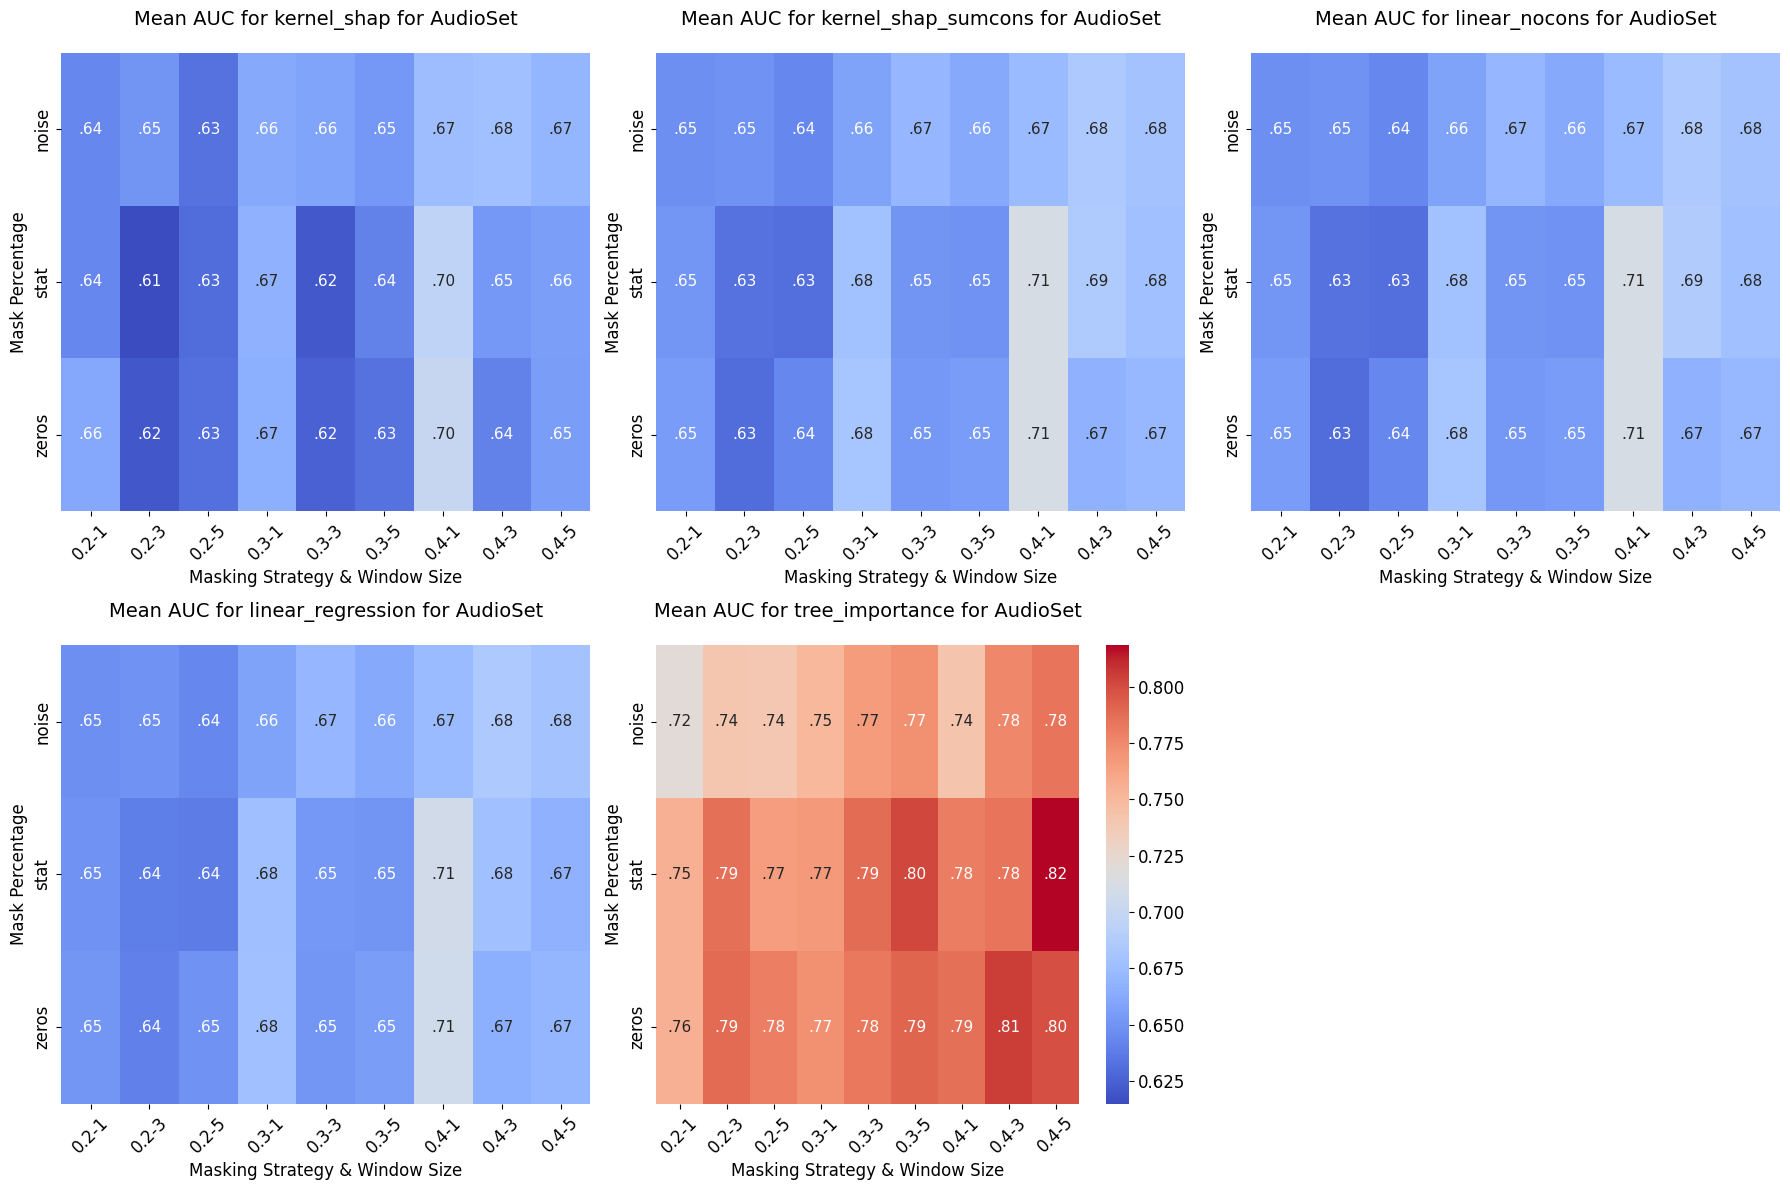

Global maximum AUC: 81.84
Global minimum AUC: 61.49


In [38]:
TITLE_SIZE = 14
LABEL_SIZE = 12
ANNOT_SIZE = 11
TICK_SIZE = 12

max_auc = multisegment['roc_auc'].max()
min_auc = multisegment['roc_auc'].min()

# Create a figure with subplots for each method
methods = multisegment['method'].unique()
n_methods = len(methods)

# Calculate number of columns and rows
n_cols = 3
n_rows = 2

# Create figure with adjusted size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 6*n_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Hide extra subplots if number of methods is odd
if n_methods < len(axes):
    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

# Custom formatter function to show only the decimal part
def format_value(val):
    # Convert to string with 3 decimal places and remove "0."
    return f"{(val-int(val))*100:.2f}"

for idx, method in enumerate(methods):
    ax = axes[idx]
    
    # Create pivot table for current method
    pivot_table = multisegment[multisegment['method'] == method].pivot(
        index='masking_strategy', 
        columns=['mask_percentage', 'window_size'], 
        values='roc_auc'
    )
    
    # Get dimensions of the pivot table
    n_rows_pivot = len(pivot_table.index)
    n_cols_pivot = len(pivot_table.columns)
    
    # Calculate aspect ratio to make cells square
    aspect = n_cols_pivot / n_rows_pivot
    
    # Create heatmap with consistent color scaling across all methods
    sns.heatmap(
        pivot_table,
        annot=pivot_table.applymap(lambda x: f"{x:.2f}".lstrip('0')),
        cmap="coolwarm",
        fmt="",  # Empty format to allow manual annotation
        ax=ax,
        vmin=min_auc,
        vmax=max_auc,
        cbar=(idx == n_methods-1),  # Only show colorbar for last plot
        annot_kws={'size': ANNOT_SIZE}  # Font size for annotation numbers
    )
    
    ax.set_title(f'Mean AUC for {method} for AudioSet', fontsize=TITLE_SIZE, pad=20)
    ax.set_xlabel('Masking Strategy & Window Size', fontsize=LABEL_SIZE)
    ax.set_ylabel('Mask Percentage', fontsize=LABEL_SIZE)
    
    # Set tick label sizes
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)
    ax.tick_params(axis='x', rotation=45)

    # If this is the last visible plot (with colorbar)
    if idx == n_methods-1:
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=TICK_SIZE)

plt.tight_layout()
plt.show()

# Print the global maximum and minimum values for reference
print(f"Global maximum AUC: {(max_auc-int(max_auc))*100:.2f}")
print(f"Global minimum AUC: {(min_auc-int(min_auc))*100:.2f}")

# Audioset viejo

In [3]:
base_path = '/home/cbolanos/explain_where/audioset_evaluation'

files_auc_new_alg = [
    f'{base_path}/auc/hyperparams/order_linear_regression_p{{}}_m{{}}.tsv',
    f'{base_path}/auc/hyperparams/order_naive_p{{}}_m{{}}.tsv',
    f'{base_path}/auc/hyperparams/order_shap_p{{}}_m{{}}.tsv',
    f'{base_path}/auc/hyperparams/order_tree_importance_p{{}}_m{{}}.tsv'
]

files_curve_new_alg = [
    f'/home/cbolanos/experiments/audioset_evaluation/leo_metric/hyperparams/score_curve_linear_regression_p{{}}_m{{}}.tsv',
    f'/home/cbolanos/experiments/audioset_evaluation/leo_metric/hyperparams/score_curve_naive_p{{}}_m{{}}.tsv',
    f'/home/cbolanos/experiments/audioset_evaluation/leo_metric/hyperparams/score_curve_shap_p{{}}_m{{}}.tsv',
    f'/home/cbolanos/experiments/audioset_evaluation/leo_metric/hyperparams/score_curve_tree_importance_p{{}}_m{{}}.tsv'
]

methods = ['linear_regression', 'naive', 'shap', 'tree_importance']

mask_percentages = [0.1, 0.15, 0.2, 0.3, 0.4]
window_sizes = [1, 2, 3, 4, 5, 6]

In [4]:
class DataMerger:
    def __init__(self, labels_segments_file: str):
        """
        Initialize the DataMerger with segment and reference files.
        
        Args:
            labels_segments_file: Path to the segments file
        """
        self.segments_df = pd.read_csv(labels_segments_file, converters={'score_curve_descending_higher': ast.literal_eval})
        self._prepare_segments()
        
    def _prepare_segments(self):
        """Prepare segment filtering based on base_segment_id and father_labels"""
        # Count segments for each base_segment_id and father_label
        self.segment_counts = (self.segments_df.groupby(['base_segment_id', 'father_labels'])
                             .size()
                             .reset_index(name='segment_count'))
        
        # Identify base_segment_ids with multiple segments
        self.segment_counts = self.segment_counts.rename(columns={
            'base_segment_id': 'filename',
            'father_labels': 'event_label'
        })
    
    def _extract_params_from_filename(self, filename: str) -> Dict[str, int]:
        """
        Extract p and m parameters from the filename.
        
        Args:
            filename: The input filename containing p and m parameters
            
        Returns:
            Dictionary containing extracted p and m values
        """
        # Extract p and m values using regex
        p_match = re.search(r'p(\d+)', filename)
        m_match = re.search(r'm(\d+)', filename)
        
        params = {}
        if p_match:
            params['p'] = int(p_match.group(1))
        if m_match:
            params['m'] = int(m_match.group(1))
            
        return params
    
    def _generate_filenames(self, 
                          file_templates: List[str], 
                          p_values: List[int], 
                          m_values: List[int]) -> List[Tuple[str, int, int]]:
        """
        Generate actual filenames by substituting p and m values.
        
        Args:
            file_templates: List of filename templates containing {} placeholders
            p_values: List of values for p parameter
            m_values: List of values for m parameter
            
        Returns:
            List of tuples containing (filename, p_value, m_value)
        """
        all_files = []
        for template in file_templates:
            for p, m in product(p_values, m_values):
                filename = template.format(p, m)
                all_files.append((filename, p, m))
        return all_files
    
    def merge_curve_and_auc(self, 
                           file_templates_curve: List[str],
                           file_templates_auc: List[str],
                           methods: List[str],
                           p_values: List[int],
                           m_values: List[int],
                           additional_merge_columns: Optional[List[str]] = None) -> pd.DataFrame:
        """
        Merge curve and AUC data with enhanced handling.
        
        Args:
            file_templates_curve: List of curve data file templates
            file_templates_auc: List of AUC data file templates
            methods: List of method names
            p_values: List of values for p parameter
            m_values: List of values for m parameter
            additional_merge_columns: Optional additional columns to include in merge
            
        Returns:
            Merged DataFrame containing both curve and AUC data
        """
        # Generate actual filenames for curve data
        all_curve_files = []
        for template, method in zip(file_templates_curve, methods):
            curve_files = self._generate_filenames([template], p_values, m_values)
            all_curve_files.extend([(f, p, m, method) for f, p, m in curve_files])
        
        # Process curve data
        all_curve_data = []
        for file, p, m, method in all_curve_files:
            try:
                df = pd.read_csv(file, sep='\t')
                df['method'] = method
                df['p'] = p
                df['m'] = m
                all_curve_data.append(df)
            except Exception as e:
                print(f"Error processing curve file {file}: {str(e)}")
                continue
        
        if not all_curve_data:
            raise ValueError("No curve data could be processed")
            
        # Combine curve data
        curve_df = pd.concat(all_curve_data, ignore_index=True)
        
        # Generate actual filenames for AUC data
        all_auc_files = []
        for template, method in zip(file_templates_auc, methods):
            auc_files = self._generate_filenames([template], p_values, m_values)
            all_auc_files.extend([(f, p, m, method) for f, p, m in auc_files])
        
        # Process AUC data
        all_auc_data = []
        for file, p, m, method in all_auc_files:
            try:
                df = pd.read_csv(file, sep='\t')
                df['method'] = method
                df['p'] = p
                df['m'] = m
                
                # Select columns for AUC data
                columns_to_keep = ['filename', 'event_label', 'roc_auc', 'method', 'p', 'm']
                if additional_merge_columns:
                    columns_to_keep.extend(additional_merge_columns)
                
                all_auc_data.append(df[columns_to_keep])
            except Exception as e:
                print(f"Error processing AUC file {file}: {str(e)}")
                continue
        
        if not all_auc_data:
            raise ValueError("No AUC data could be processed")
            
        # Combine AUC data
        auc_df = pd.concat(all_auc_data, ignore_index=True)
        
        merge_columns = ['filename', 'event_label', 'method', 'p', 'w', 'f', 'm']
        if additional_merge_columns:
            merge_columns.extend(additional_merge_columns)
            
        merged_df = curve_df.merge(
            auc_df,
            on=merge_columns,
            how='left',
            validate='many_to_one'  # Ensure proper merge relationship
        )
        

            # Then merge with the pre-calculated segment counts
        final_merged_df = merged_df.merge(
                self.segment_counts,
                on=['filename', 'event_label'],
                how='left'
            )
            
        final_merged_df['type_segment'] = np.where(
            final_merged_df['segment_count'] == 1, 'single', 'multiple')
        
        
        return final_merged_df

In [ ]:
merger = DataMerger('/home/cbolanos/experiments/audioset/labels/labels_segments.csv')

merge_df = merger.merge_curve_and_auc(files_curve_new_alg, files_auc_new_alg, methods, mask_percentages, window_sizes)

In [ ]:
merge_df['pair'] = list(zip(merge_df['filename'], merge_df['event_label']))

# Group by the specified columns and count unique pairs
grouped = merge_df.groupby(['method', 'p', 'm', 'type_segment']).agg({
    'pair': pd.Series.nunique  # Count unique (filename, event_label) pairs
}).reset_index()

# Rename the column for clarity
grouped.rename(columns={'pair': 'unique_pairs_count'}, inplace=True)

print(grouped)

In [ ]:
def calculate(list):
    list = ast.literal_eval(list)
    res = []
    for i in range(len(list)):
        if list[i] <0:
            res.append(0)
        else:
            res.append(1)
    return res

def average_drop(list, actual_score):
    list = ast.literal_eval(list)
    res = []
    
    for i in range(len(list)):
        value = actual_score - list[i]
        res.append(value)
    return res

def mean(series):
    """Calculate accuracy for each position in top-k lists across a group."""
    # Convert the series of top-k lists to a list of lists
    topk_lists = series.tolist()
    
    # Handle empty case
    if not topk_lists:
        return []
    
    # Find maximum length of top-k lists in this group
    max_length = max(len(lst) for lst in topk_lists)
    
    accuracies = []
    for i in range(max_length):
        # Collect elements at position i (if they exist)
        elements = []
        for lst in topk_lists:
            if i < len(lst):
                elements.append(lst[i])
        
        # Calculate accuracy for current position
        if elements:  # Prevent division by zero
            acc = sum(el for el in elements) / len(elements)
        else:
            acc = 0.0  # Or np.nan if you prefer to mark missing positions
        accuracies.append(acc)
    
    return accuracies
def accuracy(series):
    """Calculate accuracy for each position in top-k lists across a group."""
    # Convert the series of top-k lists to a list of lists
    topk_lists = series.tolist()
    
    # Handle empty case
    if not topk_lists:
        return []
    
    # Find maximum length of top-k lists in this group
    max_length = max(len(lst) for lst in topk_lists)
    
    accuracies = []
    for i in range(max_length):
        # Collect elements at position i (if they exist)
        elements = []
        for lst in topk_lists:
            if i < len(lst):
                elements.append(lst[i])
        
        # Calculate accuracy for current position
        if elements:  # Prevent division by zero
            acc = sum(1 for el in elements if el == 1) / len(elements)
        else:
            acc = 0.0  # Or np.nan if you prefer to mark missing positions
        accuracies.append(acc)
    
    return accuracies

merge_df['topk'] = merge_df['score_curve_descending_higher'].apply(
    lambda x: calculate(x))

merge_df['average_drop'] = merge_df.apply(
    lambda row: average_drop(row['score_curve_descending_higher'], row['actual_score']), axis=1
)

# test = merge_df[merge_df['actual_score'] >0]
merge_df['segment_category'] = merge_df['segment_count'].apply(lambda x: 'Single Segment' if x == 1 else 'Multiple Segments')

result = merge_df.groupby(['p', 'm', 'method', 'segment_category'])['topk'].apply(accuracy).reset_index()
result1 = merge_df.groupby(['p', 'm', 'method', 'segment_category'])['average_drop'].apply(mean).reset_index()

In [ ]:
sorted_data = result1.copy()
sorted_data['ff'] = sorted_data['average_drop'].apply(lambda x: x[1])
sorted_data = sorted_data.sort_values('ff', ascending=False)
sorted_data.head(50)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_dropoff_patterns(df, output_path=None):
    """
    Plot drop-off patterns for different methods with unique (p, m) combinations.
    
    Args:
        df: DataFrame with columns: method, p, m, segment_category, average_drop
        output_path: Optional path to save the figure
    """
    # Remove duplicates to get one line per method, p, m combination
    df_unique = df.drop_duplicates(subset=['method', 'p', 'm', 'segment_category'])
    
    # Special handling for 'naive': keep only the first occurrence
    df_naive_single = df_unique[(df_unique['method'] == 'naive') & (df_unique['segment_category'] == 'Single Segment')].head(1)
    df_naive_multiple = df_unique[(df_unique['method'] == 'naive') & (df_unique['segment_category'] == 'Multiple Segments')].head(1)

    df_naive = pd.concat([df_naive_single, df_naive_multiple])
    # Remove 'naive' from the unique set to avoid duplicate plotting
    df_other_methods = df_unique[(df_unique['method'] != 'naive') & (df_unique['p'] == 0.4) & (df_unique['m'] == 3)]
    
    # Combine the filtered 'naive' row with the rest
    df_filtered = pd.concat([df_naive, df_other_methods])
    
    # Get unique methods for plotting
    methods = df_filtered['method'].unique()
    n_methods = len(methods)

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 8))

    # Create color palette for methods
    palette = sns.color_palette("husl", n_colors=n_methods)

    # Plot each method's configurations
    for i, method in enumerate(methods):
        method_data = df_filtered[df_filtered['method'] == method]

        # Create scatter plot for each point
        for _, row in method_data.iterrows():
            dropoff_values = np.array(row['average_drop'])[:10]
            x = range(len(dropoff_values))[:10]

            # Plot line
            plt.plot(x, dropoff_values,
                     color=palette[i],
                     alpha=0.2,
                     linestyle='-')

            # Plot points
            plt.scatter(x, dropoff_values,
                        color=palette[i],
                        label=f"{method}, {row['p'], row['m']}",
                        alpha=0.6)

    # Customize plot
    plt.grid(True, alpha=0.3)
    plt.title('FF Patterns by Method', pad=20)
    plt.xlabel('Time Step')
    plt.ylabel('FF Value')

    # # Adjust legend
    plt.legend(bbox_to_anchor=(1.05, 1),
               loc='upper left',
               borderaxespad=0,
               fontsize=10)

    # Adjust layout
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)

    return fig

# Use the function
fig = plot_dropoff_patterns(sorted_data)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_roc_auc_heatmaps(df, output_path=None):
    """
    Create heatmaps of ROC AUC values grouped by method and segment_count (1 or >1).
    
    Args:
        df: DataFrame with columns: method, p, m, roc_auc, segment_count
        output_path: Optional path to save the figure
    """
    # Get unique methods
    methods = df['method'].unique()
    
    # Create two categories: segment_count=1 and segment_count>1
    df['segment_category'] = df['segment_count'].apply(lambda x: 'Single Segment' if x == 1 else 'Multiple Segments')
    
    # Calculate number of rows and columns needed for subplots
    n_methods = len(methods)
    n_categories = 2  # Always 2 categories now: single and multiple segments
    n_cols = 2  # Two columns for better comparison
    n_rows = n_methods  # One row per method
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for method_idx, method in enumerate(methods):
        method_data = df[df['method'] == method]
        
        for cat_idx, (category, category_label) in enumerate([
            (1, 'Single Segment'),
            (2, 'Multiple Segments')
        ]):
            # Filter data based on category
            if category == 1:
                data = method_data[method_data['segment_count'] == 1]
            else:
                data = method_data[method_data['segment_count'] > 1]
            
            # Create pivot table for heatmap
            pivot_data = data.pivot_table(
                values='roc_auc',
                index='p',
                columns='m',
                aggfunc='median'
            )
            # Create heatmap
            ax = axes[method_idx, cat_idx]
            if not pivot_data.empty:
                sns.heatmap(
                    pivot_data,
                    fmt='.3f',
                    cmap='YlOrRd',
                    ax=ax,
                    cbar_kws={'label': 'Median ROC AUC'},
                    annot_kws={"size": 12}  # Adjust as necessary
                )

                # Customize plot
                mask_percentages = pivot_data.index
                window_sizes = pivot_data.columns
                results = pivot_data.values

                for i in range(len(mask_percentages)):
                    for j in range(len(window_sizes)):
                        value = results[i, j]
                        if not np.isnan(value):
                            ax.text(j + 0.5, i + 0.5, f'{value:.3f}',
                                    ha='center', va='center',
                                    color='black', fontsize=15)

                # Customize plot
                ax.set_title(f'Method: {method}\n{category_label}', fontsize=12)
                ax.set_xlabel('Window Size', fontsize=10)
                ax.set_ylabel('Mask Percentage', fontsize=10)
                ax.tick_params(axis='x', rotation=45)

    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Fine-tune layout

    if output_path:
        plt.savefig(output_path, bbox_inches='tight', dpi=300)
        
    return fig

fig = plot_roc_auc_heatmaps(merge_df, 'heatmaps.png')